<a href="https://colab.research.google.com/github/Mandlez/Finance/blob/main/Efficient_frontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
import re
from io import StringIO
from datetime import datetime, timedelta
import requests
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [ ]:
start_date = "2019-01-01"
end_date = "2023-01-01"
symbols = ["VLTSA.PA", "OR.PA", "SQI.PA", "ALEMG.PA", "FDE.PA", "SU.PA", "FII.PA", "MC.PA",
    "AIR.PA", "SAF.PA", "GE", "NEOEN.PA", "VIV.PA", "RBT.PA", "AI.PA", "GTT.PA", "RMS.PA", "ESI.PA", "AZN", "TSLA"]
stocks_df = yf.download(symbols, start = start_date, end = end_date)['Adj Close']
stocks_df.head().dropna()


[*********************100%%**********************]  20 of 20 completed


,AI.PA,AIR.PA,ALEMG.PA,AZN,ESI.PA,FDE.PA,FII.PA,GE,GTT.PA,MC.PA,NEOEN.PA,OR.PA,RBT.PA,RMS.PA,SAF.PA,SQI.PA,SU.PA,TSLA,VIV.PA,VLTSA.PA
Date,,,,,,,,,,,,,,,,,,,,
2019-01-02,79.245094,78.120621,6.6,33.105091,27.150000,11.30,21.223194,47.404743,54.151302,232.625549,18.914120,183.077667,483.915802,462.388885,100.064110,16.139999,52.222748,20.674667,18.910677,7.952106
2019-01-03,77.788651,75.373360,6.6,33.569271,27.450001,11.35,20.983112,47.463634,54.928986,223.763184,18.794912,180.876312,487.741211,449.222107,97.791023,15.900000,50.776527,20.024000,18.741512,7.933307
2019-01-04,79.954636,79.002342,6.6,34.313690,27.850000,11.80,21.559307,48.464722,55.706669,230.651001,18.715443,183.444565,501.130188,462.582428,101.756828,16.059999,52.663673,21.179333,19.062035,7.942707
2019-01-07,79.506493,77.554459,6.6,33.963371,27.000000,11.80,21.751371,51.468010,55.870392,230.237732,18.933987,181.105652,506.868286,457.160858,100.064110,16.100000,52.434387,22.330667,19.266809,7.895708
2019-01-08,79.618538,80.422379,6.6,33.394108,28.200001,13.00,23.768055,50.408028,55.624809,237.447006,19.371078,182.206299,493.479370,464.615631,102.965927,16.420000,52.840038,22.356667,19.320230,7.764113


In [ ]:
stocks_df.tail()

,AI.PA,AIR.PA,ALEMG.PA,AZN,ESI.PA,FDE.PA,FII.PA,GE,GTT.PA,MC.PA,NEOEN.PA,OR.PA,RBT.PA,RMS.PA,SAF.PA,SQI.PA,SU.PA,TSLA,VIV.PA,VLTSA.PA
Date,,,,,,,,,,,,,,,,,,,,
2022-12-23,131.290619,110.171593,4.54,66.570320,72.800003,38.049999,19.085487,63.656475,98.465782,663.311829,38.137272,328.625824,826.479614,1433.316040,116.419708,43.700001,128.577881,123.150002,8.712449,17.080000
2022-12-27,131.506653,111.236435,4.45,66.521355,73.599998,38.099998,19.184891,64.473679,98.271950,679.456604,38.017780,332.077240,826.479614,1462.618042,118.202248,43.700001,129.852097,109.099998,8.663722,16.959999
2022-12-28,130.956757,110.053284,4.34,66.159027,73.800003,37.549999,19.880716,63.796566,97.787376,675.912659,37.639393,330.745972,836.377563,1452.685303,116.835640,44.000000,129.205200,112.709999,8.650079,16.940001
2022-12-29,132.272598,110.447662,4.51,66.687828,73.800003,39.150002,19.880716,65.181931,98.271950,685.658569,37.838547,334.000214,829.448975,1475.034180,116.875244,44.000000,130.851868,121.820000,8.784566,17.240000
2022-12-30,130.014053,109.461700,4.81,66.394051,73.800003,39.400002,19.343935,65.213058,96.721313,669.316956,37.450203,328.970978,828.459167,1435.302612,115.785919,44.000000,128.127014,123.180000,8.687111,17.059999


In [ ]:
num_portfolios = 100000  # Nombre de portefeuilles à simuler
num_stocks = len(symbols)  # Nombre d'actions dans le portefeuille
stock_weights = []

for _ in range(num_portfolios):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    stock_weights.append(weights)
daily_returns = stocks_df.pct_change()
annual_return = (daily_returns.mean() * 250) + 1
cov_daily = daily_returns.cov()
cov_annual = cov_daily*250
print(annual_return)

AI.PA       1.143826
AIR.PA      1.183149
ALEMG.PA    1.420204
AZN         1.204984
ESI.PA      1.281137
FDE.PA      1.392875
FII.PA      1.077324
GE          1.172374
GTT.PA      1.195518
MC.PA       1.299288
NEOEN.PA    1.240210
OR.PA       1.172662
RBT.PA      1.169483
RMS.PA      1.311246
SAF.PA      1.129196
SQI.PA      1.302551
SU.PA       1.260175
TSLA        1.649263
VIV.PA      0.923332
VLTSA.PA    1.260487
dtype: float64


In [ ]:
num_portfolios = 10000  # Nombre de portefeuilles à simuler
num_stocks = 20  # Nombre d'actions dans votre portefeuille
risk_free_rate = 0.0325  # Taux sans risque pour le calcul du ratio de Sharpe

# Containers pour les résultats
portfolio_returns = []
portfolio_volatility = []
sharpe_ratios = []
stock_weights = []

for _ in range(num_portfolios):
    # Générer des poids aléatoires pour chaque action
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    stock_weights.append(weights)

    # Calculer le rendement et la volatilité du portefeuille pour les poids générés
    returns = np.sum(weights * daily_returns.mean()) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))

    # Calculer le ratio de Sharpe
    sharpe_ratio = (returns - risk_free_rate) / volatility

    # Ajouter les résultats aux listes
    portfolio_returns.append(returns)
    portfolio_volatility.append(volatility)
    sharpe_ratios.append(sharpe_ratio)

# Créer un DataFrame avec les résultats
portfolio_data = {
    'Returns': portfolio_returns,
    'Volatility': portfolio_volatility,
    'Sharpe Ratio': sharpe_ratios
}

# Ajouter les poids des actions au DataFrame
for counter, symbol in enumerate(symbols):
    portfolio_data[symbol + ' Weight'] = [weights[counter] for weights in stock_weights]

df = pd.DataFrame(portfolio_data)
df

,Returns,Volatility,Sharpe Ratio,VLTSA.PA Weight,OR.PA Weight,SQI.PA Weight,ALEMG.PA Weight,FDE.PA Weight,SU.PA Weight,FII.PA Weight,...,GE Weight,NEOEN.PA Weight,VIV.PA Weight,RBT.PA Weight,AI.PA Weight,GTT.PA Weight,RMS.PA Weight,ESI.PA Weight,AZN Weight,TSLA Weight
0,0.218823,0.197969,0.941172,0.072536,0.010367,0.077577,0.015505,0.055887,0.026171,0.060354,...,0.026706,0.067616,0.044096,0.021349,0.053308,0.037832,0.061384,0.019721,0.073711,0.061262
1,0.214219,0.194256,0.935463,0.078496,0.072889,0.023625,0.092973,0.051300,0.003789,0.086012,...,0.017378,0.016466,0.068290,0.078425,0.066954,0.072695,0.048553,0.029243,0.034022,0.002903
2,0.282291,0.199188,1.254047,0.022865,0.023735,0.022157,0.018105,0.014676,0.098922,0.053195,...,0.101935,0.023936,0.015773,0.063908,0.017385,0.108414,0.083896,0.093946,0.039790,0.063766
3,0.250364,0.205915,1.058029,0.114927,0.005536,0.081724,0.015656,0.024162,0.067505,0.080239,...,0.009983,0.048536,0.069784,0.050411,0.045053,0.043216,0.055342,0.052624,0.001411,0.024570
4,0.277224,0.197436,1.239512,0.056224,0.077201,0.033269,0.067809,0.010603,0.060367,0.014410,...,0.034705,0.086033,0.024063,0.044256,0.003854,0.084361,0.077887,0.092661,0.012850,0.079213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.269403,0.209081,1.133064,0.020782,0.080147,0.068201,0.031313,0.075042,0.023830,0.015947,...,0.049405,0.036594,0.021737,0.016574,0.060104,0.070584,0.081443,0.058750,0.003362,0.069752
9996,0.237992,0.185577,1.107319,0.069622,0.002470,0.043258,0.037123,0.066498,0.037413,0.051227,...,0.071043,0.061206,0.063027,0.038739,0.065136,0.059242,0.067388,0.059466,0.057443,0.042931
9997,0.232739,0.201515,0.993668,0.064571,0.010515,0.011464,0.074286,0.024088,0.072510,0.075529,...,0.009789,0.066142,0.043978,0.028774,0.090624,0.092999,0.036404,0.082613,0.082064,0.018256
9998,0.261049,0.194226,1.176713,0.065850,0.008961,0.066422,0.043827,0.082679,0.052442,0.040896,...,0.091110,0.093008,0.055330,0.083360,0.085281,0.011313,0.004487,0.049583,0.001347,0.068733


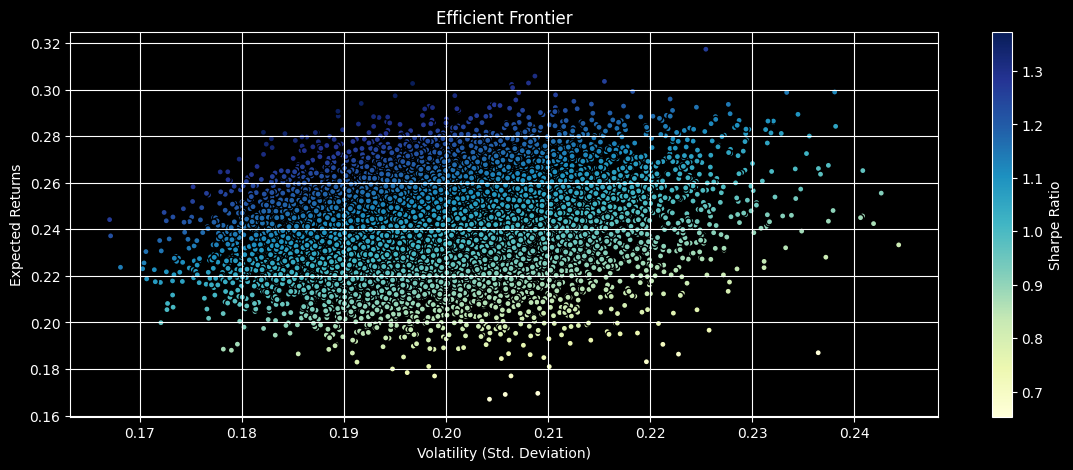

In [ ]:
import matplotlib.pyplot as plt

df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='YlGnBu', edgecolors='black', figsize=(14, 5), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

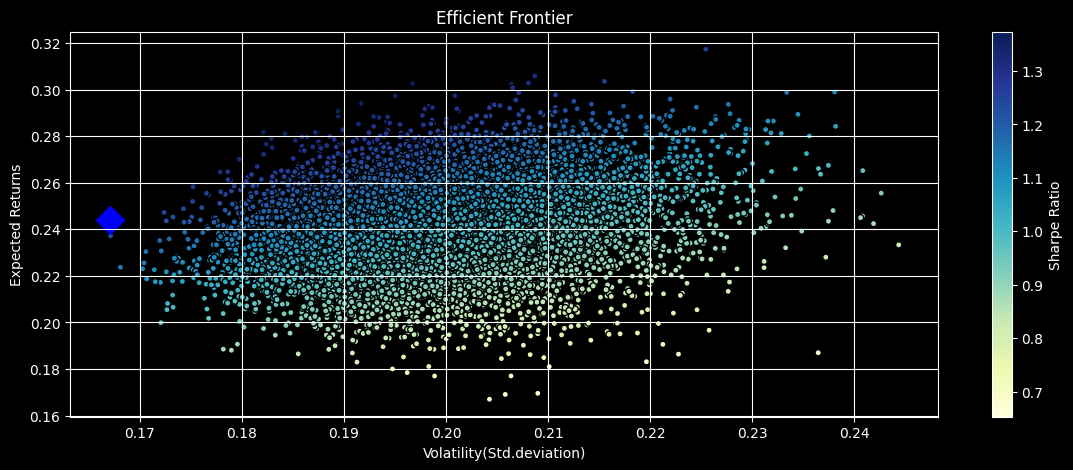

In [ ]:
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

plt.style.use("dark_background")
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='YlGnBu', edgecolors='black', figsize=(14, 5), grid=True)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200)
plt.xlabel('Volatility(Std.deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
r_ef = pd.concat([min_variance_port.T,sharpe_portfolio.T], axis = 1)
r_ef.columns = ["Minimum Risk Adjusted Values", "Max Risk Adjusted Values"]
print(r_ef)

                 Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                              0.244164                  0.302649
Volatility                           0.167038                  0.196719
Sharpe Ratio                         1.267159                  1.373278
VLTSA.PA Weight                      0.070841                  0.006744
OR.PA Weight                         0.005250                  0.006760
SQI.PA Weight                        0.038670                  0.038720
ALEMG.PA Weight                      0.054273                  0.025744
FDE.PA Weight                        0.110910                  0.108760
SU.PA Weight                         0.044848                  0.092442
FII.PA Weight                        0.015403                  0.043435
MC.PA Weight                         0.025404                  0.036345
AIR.PA Weight                        0.070907                  0.020961
SAF.PA Weight                        0.054156                  0